# Exp6: 基于集成学习的 Amazon 用户评论质量预测

## 一、案例简介

随着电商平台的兴起，以及疫情的持续影响，线上购物在我们的日常生活中扮演着越来越重要的角色。在进行线上商品挑选时，评论往往是我们十分关注的一个方面。然而目前电商网站的评论质量参差不齐，甚至有水军刷好评或者恶意差评的情况出现，严重影响了顾客的购物体验。因此，对于评论质量的预测成为电商平台越来越关注的话题，如果能自动对评论质量进行评估，就能根据预测结果避免展现低质量的评论。本案例中我们将基于集成学习的方法对 Amazon 现实场景中的评论质量进行预测。

## 二、作业说明

本案例中需要大家完成两种集成学习算法的实现（Bagging、AdaBoost.M1），其中基分类器要求使用 SVM 和决策树两种，因此，一共需要对比四组结果（[AUC](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) 作为评价指标）：

* Bagging + SVM
* Bagging + 决策树
* AdaBoost.M1 + SVM
* AdaBoost.M1 + 决策树

注意集成学习的核心算法需要**手动进行实现**，基分类器可以调库。

### 基本要求
* 根据数据格式设计特征的表示
* 汇报不同组合下得到的 AUC
* 结合不同集成学习算法的特点分析结果之间的差异
* （使用 sklearn 等第三方库的集成学习算法会酌情扣分）

### 扩展要求
* 尝试其他基分类器（如 k-NN、朴素贝叶斯）
* 分析不同特征的影响
* 分析集成学习算法参数的影响

## 三、数据概览

In [32]:
import numpy as np
import pandas as pd
train_df = pd.read_csv('./data/train.csv', sep='\t')
test_df = pd.read_csv('./data/test.csv', sep='\t')
y_test_df = pd.read_csv('./groundTruth.csv', sep=',')

In [33]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57039 entries, 0 to 57038
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewerID  57039 non-null  int64  
 1   asin        57039 non-null  int64  
 2   reviewText  57039 non-null  object 
 3   overall     57039 non-null  float64
 4   votes_up    57039 non-null  int64  
 5   votes_all   57039 non-null  int64  
 6   label       57039 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 3.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11208 entries, 0 to 11207
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          11208 non-null  int64  
 1   reviewerID  11208 non-null  int64  
 2   asin        11208 non-null  int64  
 3   reviewText  11208 non-null  object 
 4   overall     11208 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 437.9+ KB


本次数据来源于 Amazon 电商平台，包含超过 50,000 条用户在购买商品后留下的评论，各列的含义如下：

* reviewerID：用户 ID
* asin：商品 ID
* reviewText：英文评论文本
* overall：用户对商品的打分（1-5）
* votes_up：认为评论有用的点赞数（只在训练集出现）
* votes_all：该评论得到的总评价数（只在训练集出现）
* label：评论质量的 label，1 表示高质量，0 表示低质量（只在训练集出现）

评论质量的 label 来自于其他用户对评论的 votes，votes_up/votes_all ≥ 0.9 的作为高质量评论。此外测试集包含一个额外的列Id，标识了每一个测试的样例。

## 四、比赛提交格式

课程页面：https://aistudio.baidu.com/aistudio/education/dashboard

提交文件需要对测试集中每一条评论给出预测为高质量的概率，每行包括一个Id（和测试集对应）以及预测的概率Predicted（0-1的浮点数），用逗号分隔。示例提交格式如下：

```
Id,Predicted
0,0.9
1,0.45
2,0.78
...
```
命名为`result.csv`

**注意除了提交比赛，还需要像之前作业一样在学堂在线提交代码和报告（不包括数据）**

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import pandas as pd

# 实现Bagging算法
def bagging(X, y=None, sampling_rate=0.8, iter=5, classifier_name=None):
    models = []  # trained models list
    # boostrap sampling
    for i in range(iter):
        # random train set - bootstrap sampling
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=sampling_rate)
        classifier = new_base_classifier(classifier_name)
        clf = classifier.fit(X_train, y_train)
        models.append(clf)
    print("Bagging using base classifier = '{}', End with iter = {}".format(classifier_name, iter))

    # max count as the final result (equal weighted or weighted based on vote_up/vote_all todo)
    def predict(X_test):
        y_test_predict_list = [models[i].predict_proba(X_test) for i in range(len(models))]
        # [np.argmax(np.bincount(item)) for item in np.array(y_test_predict_list).T]
        # 根据组合概率判定类别
        proba_arr = np.zeros((X_test.shape[0], 2))
        for item in y_test_predict_list:
            proba_arr += item
        return [item[1]/len(models) for item in proba_arr]

    return predict


In [35]:
# 实现AdaBoost.M1算法
def ada_boost_m1(X, y=None, classifiers_map=None, iter=5):
    """
    :param classifiers_map: different classifiers(map): Decision Tree, K-NN, SVM, etc
    """
    classifier_names_arr = list(classifiers_map.keys())
    cn_index = 0
    classifier_name = classifier_names_arr[cn_index]
    curr_base_classifier = classifiers_map[classifier_name]
    classifier_changed = False
    X_copy = np.copy(X)
    models = []
    coeff = []
    classifier_in_use_names = []
    weights = np.ones(X.shape[0], dtype=np.float64) / X.shape[0]  # votes_up/votes_all may be as the initial weights
    num = 0
    while num < iter:
        clf = curr_base_classifier.fit(X, y)
        y_predict = clf.predict(X)
        y_diff = (y - y_predict)  # -1/0/1
        print("==> train_predict_error = {}".format(len(weights[y_diff != 0]) / float(len(weights))))
        # calculate error ratio
        e = np.sum(weights[y_diff != 0])
        if e == 0.0:
            print( "Error ratio of sample classification is 0: classifier = '{}', iter = {}".format(classifier_name, num))
            e = 1e-16  # 防止零溢出
        if e >= 0.5:
            # raise Exception("iter = %d, e = %.4f, and need to change a better classifier" % (i, e))
            print("ERROR >= 0.5, AdaBoost.M1 using '{}', end with e = {}, and iter = {}".format(classifier_name, e, num))
            print("Change to another type of classifier and continue...")
            cn_index = cn_index + 1
            while cn_index < len(classifier_names_arr):
                name = classifier_names_arr[cn_index]
                if name not in classifier_in_use_names:
                    break
                cn_index = cn_index + 1
            if cn_index >= len(classifier_names_arr):
                print("No available classifier")
                num = iter
                continue
            # change to another classifier and go back to fit previous X
            classifier_name = classifier_names_arr[cn_index]
            curr_base_classifier = classifiers_map[classifier_name]
            X = X_copy
            if not classifier_changed:
                num = num - 1
                classifier_changed = True
            continue
        # adjust weights
        factor = e / (1 - e)
        for index in range(len(weights)):
            weights[index] = (weights[index] * factor) if y_diff[index] == 0.0 else weights[index]
        weights /= sum(weights)
        X = np.multiply(weights.reshape(-1, 1), X)
        X_copy = np.copy(X)
        models.append(clf)
        coeff.append(np.log(1 / factor))
        # 每次拟合后，若基分类器不变，下次拟合仍需要使用基分类器，而不是由基分类器拟合数据而得到的分类器实例！！！
        # 如果使用分类器实例，则现象是得到的predict_proba一样，最终的predict概率也会一样！！！
        curr_base_classifier = new_base_classifier(classifier_name)
        classifier_in_use_names.append(classifier_name)
        classifier_changed = False
        num = num + 1
    print("AdaBoost.M1 using base classifier = '{}', End normally with iter = {}".format(
        ','.join(classifier_in_use_names), num))

    def predict(X_test):
        coeff_sum = sum(coeff)
        y_test_predict_list = [(models[i].predict_proba(X_test) * coeff[i] / coeff_sum) for i in range(len(models))]
        message = ["{}*{}".format(np.around(coeff[i] / coeff_sum, 4), classifier_in_use_names[i]) for i in range(len(models))]
        proba_arr = np.zeros((X_test.shape[0], 2))
        # 根据组合概率判定类别
        for item in y_test_predict_list:
            proba_arr += item
        return [item[1] for item in proba_arr], '+'.join(message)

    return predict

In [36]:
# Base classifier creator
def new_base_classifier(classifier_name):
    bc = None
    if classifier_name == 'SVM':
        bc = CalibratedClassifierCV(LinearSVC(dual=False))
    elif classifier_name == 'DecisionTree':
        bc = DecisionTreeClassifier()
    elif classifier_name == 'NaiveBayes':
        bc = MultinomialNB()
    elif classifier_name == 'KNN':
        bc = KNeighborsClassifier(n_neighbors=2)
    else:
        raise Exception("Unknown classifier_name = {}".format(classifier_name))
    return bc

In [37]:
# 根据数据格式设计特征的表示
### 提取特征，考虑评论文本长度同评论质量会有一定相关性
max_features = 5000
# 加载停用词
stop_words = []
for word in open('./stopwords-en.txt', encoding='utf8', mode='r'):
    stop_words.append(word.strip())

## 特征值化训练集
review_df = train_df['reviewText']
vectorizer = TfidfVectorizer(max_features=max_features, min_df=0.02, max_df=1.0, stop_words=stop_words)
vectorizer.fit(review_df)
print("text features' length =", len(vectorizer.get_feature_names_out()))
review_feat_arr = vectorizer.transform(review_df).toarray()
# 加入评论文本长度作为特征之一（长评论意味着高质量的概率大）
review_length_arr = [len(item) for item in review_df]
features_arr = np.concatenate(
    (review_feat_arr, train_df['overall'].values.reshape(-1, 1), np.reshape(review_length_arr, (-1, 1))), axis=1)
# 归一化 ['reviewText', 'overall', 评论文本长度] 三列
scaler = MinMaxScaler()
X_train = scaler.fit_transform(features_arr)
y_train = train_df['label'].values

## 特征值化测试集
review_df = test_df['reviewText']
review_feat_arr = vectorizer.transform(review_df).toarray()
# 加入评论文本长度作为特征之一（长评论意味着高质量的概率大）
review_length_arr = [len(item) for item in review_df]
features_arr = np.concatenate(
    (review_feat_arr, test_df['overall'].values.reshape(-1, 1), np.reshape(review_length_arr, (-1, 1))), axis=1)
# 归一化 ['reviewText', 'overall', 评论文本长度] 三列
scaler = MinMaxScaler()
X_test = scaler.fit_transform(features_arr)
y_test = y_test_df['Expected'].values


text features' length = 580


In [38]:
# 汇报不同组合下得到的 AUC
### 实例化各个分类器
clf_dict = {
    'DecisionTree': new_base_classifier("DecisionTree"),
    'SVM': new_base_classifier("SVM"),
    'NaiveBayes': new_base_classifier("NaiveBayes"),
    # 'KNN': new_base_classifier("KNN")
}
for key, value in clf_dict.items():
    ## Base classifier
    base_classifier = value
    clf = base_classifier.fit(X_train, y_train)
    y_test_predict = clf.predict(X_test)
    print("Accuracy using ({}) = {}".format(key, accuracy_score(y_test, y_test_predict)))
    print("AUC using ({}) = {}".format(key, roc_auc_score(y_test, y_test_predict)))
    print("---------------------------------------------------------------------")
    ## Bagging
    bagg = bagging(X_train, y_train, sampling_rate=0.8, iter=5, classifier_name=key)
    y_test_predict_bagg_proba = bagg(X_test)
    y_test_predict_bagg = [1 if item >= 0.5 else 0 for item in y_test_predict_bagg_proba]
    print("Accuracy using (Bagging + {}) = {}".format(key, accuracy_score(y_test, y_test_predict_bagg)))
    print("AUC using (Bagging + {}) = {}".format(key, roc_auc_score(y_test, y_test_predict_bagg)))
    print("*********************************************************************")
    # 生成结果文件
    res_id_col = np.arange(X_test.shape[0], dtype=int).reshape(-1, 1)
    res_bagg_predict_col = np.reshape(y_test_predict_bagg_proba, (-1, 1))
    df = pd.DataFrame(np.concatenate((res_id_col, res_bagg_predict_col), axis=1), columns=['Id', 'Predicted'])
    df.to_csv("./Exp6-Bagging-{}.csv".format(key), index=False)
    ## AdaBoost.M1
    base_classifiers_map = dict()
    base_classifiers_map[key] = new_base_classifier(key)
    for k, v in clf_dict.items():
        if k != key:
            base_classifiers_map[k] = new_base_classifier(k)
    ada_boost = ada_boost_m1(X_train, y_train, iter=20, classifiers_map=base_classifiers_map)
    y_test_predict_ada_boost_proba, classifier_names = ada_boost(X_test)
    y_test_predict_ada_boost = [1 if item >= 0.5 else 0 for item in y_test_predict_ada_boost_proba]
    print("Accuracy using (AdaBoost.M1: {}) = {}".format(classifier_names, accuracy_score(y_test, y_test_predict_ada_boost)))
    print("AUC using (AdaBoost.M1: {}) = {}".format(classifier_names, roc_auc_score(y_test, y_test_predict_ada_boost)))
    # 生成结果文件
    res_adaboost_predict_col = np.reshape(y_test_predict_ada_boost_proba, (-1, 1))
    df = pd.DataFrame(np.concatenate((res_id_col, res_adaboost_predict_col), axis=1), columns=['Id', 'Predicted'])
    classifier_names = classifier_names.replace("*", "x")
    df.to_csv("./Exp6-AdaBoost-{}.csv".format(classifier_names), index=False)
    print("#####################################################################")


Accuracy using (DecisionTree) = 0.7131513204853676
AUC using (DecisionTree) = 0.5968881321547601
---------------------------------------------------------------------
Bagging using base classifier = 'DecisionTree', End with iter = 5
Accuracy using (Bagging + DecisionTree) = 0.7486616702355461
AUC using (Bagging + DecisionTree) = 0.5955191358959835
*********************************************************************
==> train_predict_error = 0.0
Error ratio of sample classification is 0: classifier = 'DecisionTree', iter = 0
==> train_predict_error = 8.765932081558232e-05
==> train_predict_error = 0.22610845211171304
==> train_predict_error = 0.22619611143252863
ERROR >= 0.5, AdaBoost.M1 using 'DecisionTree', end with e = 0.7818693103749933, and iter = 3
Change to another type of classifier and continue...
==> train_predict_error = 0.22619611143252863
ERROR >= 0.5, AdaBoost.M1 using 'SVM', end with e = 0.7818693103749933, and iter = 2
Change to another type of classifier and continue..

### 结合不同集成学习算法的特点分析结果之间的差异
根据以上输出结果分析如下，

如下AUC指标表明，Bagging和AdaBoost在弱分类器作为基分类器的情形下，大概率好于单个分类器的预测结果

1. (AdaBoost.M1 + DecisionTree) > (DecisionTree) > (Bagging + DecisionTree)

AUC using (DecisionTree) = 0.5968881321547601

AUC using (Bagging + DecisionTree) = 0.5955191358959835

AUC using (AdaBoost.M1: 0.7637*DecisionTree+0.1936*DecisionTree+0.0427*DecisionTree) = 0.5985354148278905


2. (SVM) > (Bagging + SVM) > (AdaBoost.M1 + SVM)

AUC using (SVM) = 0.6339288360711887

AUC using (Bagging + SVM) = 0.6315187357563462

AUC using (AdaBoost.M1: 0.8567*SVM+0.1433*SVM+0.0*SVM) = 0.6139545816811792


3. (Bagging + NaiveBayes) > (NaiveBayes) > (AdaBoost.M1 + NaiveBayes)

AUC using (NaiveBayes) = 0.5262153212314422

AUC using (Bagging + NaiveBayes) = 0.5267369024252084

AUC using (AdaBoost.M1: 0.9788*NaiveBayes+0.0212*NaiveBayes) = 0.5251896546613797


### 尝试其他基分类器（如 k-NN、朴素贝叶斯）
以上实验对比中已加入朴素贝叶斯分类器（k-NN运行时间有些长，暂未加入对比）
### 分析不同特征的影响
根据如下程序运行结果图示，
1. AdaBoost算法下，Accuracy和AUC均在特征数量300左右达到最低；
2. Bagging算法下，Accuracy和AUC在特征数量300左右达到最低；

In [39]:
train_review_df = train_df['reviewText']
test_review_df = test_df['reviewText']
x_axis = [50, 100, 300, 500]
acc_arr = []
auc_arr = []
for max_features in x_axis:
    vectorizer = TfidfVectorizer(max_features=max_features, min_df=0.02, max_df=1.0, stop_words=stop_words)
    vectorizer.fit(train_review_df)
    print("text features' length =", len(vectorizer.get_feature_names_out()))
    ## 特征值化训练集
    review_feat_arr = vectorizer.transform(train_review_df).toarray()
    review_length_arr = [len(item) for item in train_review_df]
    features_arr = np.concatenate(
        (review_feat_arr, train_df['overall'].values.reshape(-1, 1), np.reshape(review_length_arr, (-1, 1))), axis=1)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(features_arr)
    y_train = train_df['label'].values
    ## 特征值化测试集
    review_feat_arr = vectorizer.transform(test_review_df).toarray()
    review_length_arr = [len(item) for item in test_review_df]
    features_arr = np.concatenate(
        (review_feat_arr, test_df['overall'].values.reshape(-1, 1), np.reshape(review_length_arr, (-1, 1))), axis=1)
    scaler = MinMaxScaler()
    X_test = scaler.fit_transform(features_arr)
    y_test = y_test_df['Expected'].values
    ## Bagging
    bagg = bagging(X_train, y_train, sampling_rate=0.8, iter=5, classifier_name="DecisionTree")
    y_test_predict_bagg_proba = bagg(X_test)
    y_test_predict_bagg = [1 if item >= 0.5 else 0 for item in y_test_predict_bagg_proba]
    acc_bagg = accuracy_score(y_test, y_test_predict_bagg)
    auc_bagg = roc_auc_score(y_test, y_test_predict_bagg)
    print("Accuracy using (Bagging + {}) = {}".format("DecisionTree", acc_bagg))
    print("AUC using (Bagging + {}) = {}".format("DecisionTree", auc_bagg))
    ## AdaBoost
    clf_dict = {
        'DecisionTree': new_base_classifier("DecisionTree")
    }
    ada_boost = ada_boost_m1(X_train, y_train, iter=20, classifiers_map=clf_dict)
    y_test_predict_ada_boost_proba, classifier_names = ada_boost(X_test)
    y_test_predict_ada_boost = [1 if item >= 0.5 else 0 for item in y_test_predict_ada_boost_proba]
    acc_ada_boost = accuracy_score(y_test, y_test_predict_ada_boost)
    auc_ada_boost = roc_auc_score(y_test, y_test_predict_ada_boost)
    print("Accuracy using (AdaBoost.M1: {}) = {}".format(classifier_names, acc_ada_boost))
    print("AUC using (AdaBoost.M1: {}) = {}".format(classifier_names, auc_ada_boost))
    acc_arr.append((acc_bagg, acc_ada_boost))
    auc_arr.append((auc_bagg, auc_ada_boost))
    print("============== max_features =", max_features, "end ==============")


text features' length = 50
Bagging using base classifier = 'DecisionTree', End with iter = 5
Accuracy using (Bagging + DecisionTree) = 0.7657922912205567
AUC using (Bagging + DecisionTree) = 0.585991325367865
==> train_predict_error = 0.0005785515173828433
==> train_predict_error = 0.008730868353231998
==> train_predict_error = 0.22565262364347202
ERROR >= 0.5, AdaBoost.M1 using 'DecisionTree', end with e = 0.5391134137091597, and iter = 2
Change to another type of classifier and continue...
No available classifier
AdaBoost.M1 using base classifier = 'DecisionTree,DecisionTree', End normally with iter = 20
Accuracy using (AdaBoost.M1: 0.5786*DecisionTree+0.4214*DecisionTree) = 0.734475374732334
AUC using (AdaBoost.M1: 0.5786*DecisionTree+0.4214*DecisionTree) = 0.5803385296597331
============== max_features = 50 end ==============
text features' length = 100
Bagging using base classifier = 'DecisionTree', End with iter = 5
Accuracy using (Bagging + DecisionTree) = 0.7635617416131335
AUC

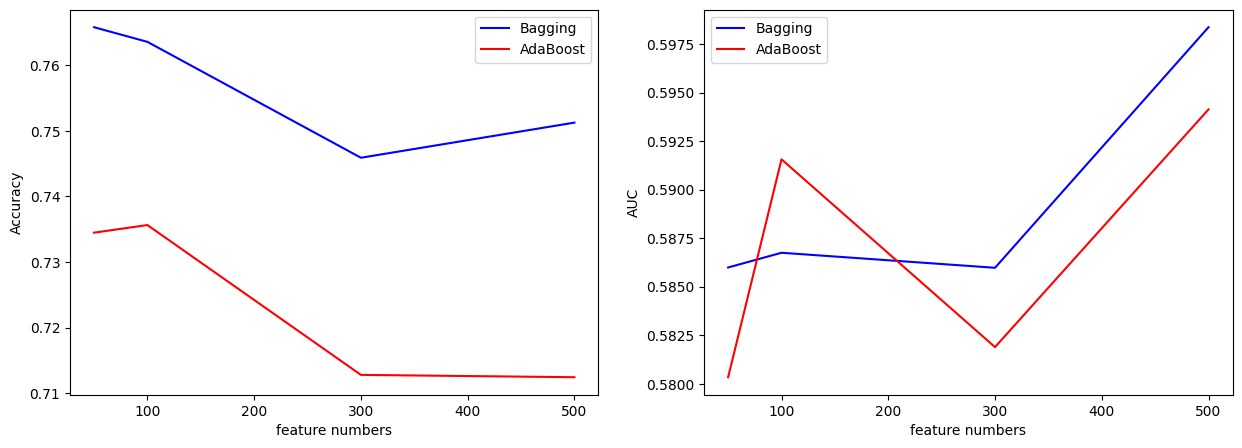

In [40]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(x_axis, [item[0] for item in acc_arr], color='blue', label='Bagging')
plt.plot(x_axis, [item[1] for item in acc_arr], color='red', label='AdaBoost')
plt.xlabel('feature numbers')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(122)
plt.plot(x_axis, [item[0] for item in auc_arr], color='blue', label='Bagging')
plt.plot(x_axis, [item[1] for item in auc_arr], color='red', label='AdaBoost')
plt.xlabel('feature numbers')
plt.ylabel('AUC')
plt.legend()
plt.show()

### 分析集成学习算法参数的影响
针对Bagging算法，设置采样率0.6、决策树分类器，观察Accuracy和AUC随不同迭代次数的变化趋势。
如下程序运行结果所示，
1. Accuracy随迭代次数增多呈升高，最终趋于不变
2. AUC随迭代次数增多变化平缓，总体上受迭代次数影响较小

Bagging using base classifier = 'DecisionTree', End with iter = 2
Bagging using base classifier = 'DecisionTree', End with iter = 5
Bagging using base classifier = 'DecisionTree', End with iter = 10
Bagging using base classifier = 'DecisionTree', End with iter = 20
Bagging using base classifier = 'DecisionTree', End with iter = 35
Bagging using base classifier = 'DecisionTree', End with iter = 50


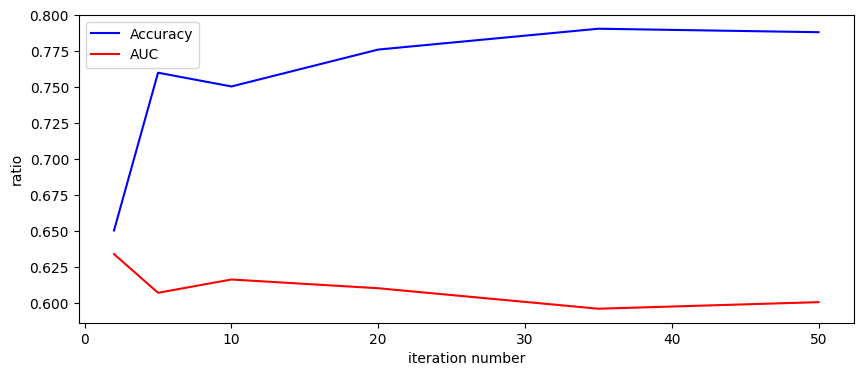

In [41]:
iter_num = [2, 5, 10, 20, 35, 50]
acc_arr = []
auc_arr = []
for num in iter_num:
    bagg = bagging(X_train, y_train, sampling_rate=0.6, iter=num, classifier_name="DecisionTree")
    y_test_predict_bagg_proba = bagg(X_test)
    y_test_predict_bagg = [1 if item >= 0.5 else 0 for item in y_test_predict_bagg_proba]
    acc_bagg = accuracy_score(y_test, y_test_predict_bagg)
    auc_bagg = roc_auc_score(y_test, y_test_predict_bagg)
    acc_arr.append(acc_bagg)
    auc_arr.append(auc_bagg)

plt.figure(figsize=(10,4))
plt.plot(iter_num, acc_arr, color='blue', label='Accuracy')
plt.plot(iter_num, auc_arr, color='red', label='AUC')
plt.xlabel('iteration number')
plt.ylabel('ratio')
plt.legend()